## Housing Price Prediction for property company Suprise Housing
### Introduction
US-based housing company named Surprise Housing has decided to enter the Australian market. The company is using data analytics to purchase houses at a price below their actual values and flip them on at a higher price.

### Objective: 
To find
- Which variables are significant to predict the price of a house
- And how well those variables describe the price of a house

### Business Goal:
- To model the price of houses with the available independent variables.
- Understanding how the prices vary with the variables.
- to understand the pricing dynamics of a new market in Australia.

### Import libraries and environment setup

In [1]:
# for data
import pandas as pd
import numpy as np

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set() # Setting seaborn as default style

# for machine learning
from sklearn import model_selection
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 1. EDA

### Read and understand the data

In [2]:
# Import and read housing price data
house_df = pd.read_csv('train.csv')
house_df.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [3]:
# Check size
house_df.shape

(1460, 81)

In [4]:
# To check columns- name, data_types and with nulls.
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# Check for any duplicate records
sum(house_df.duplicated())

0

In [6]:
# Check unique values in all columns(look for highly skewed Columns)
print(house_df.nunique().sort_values())

CentralAir         2
Utilities          2
Street             2
Alley              2
BsmtHalfBath       3
                ... 
1stFlrSF         753
BsmtUnfSF        780
GrLivArea        861
LotArea         1073
Id              1460
Length: 81, dtype: int64


#### Findings:
- Total 81 variables are there, out of which Id variable is unique for each record(unique index)  
- no duplicate records found in 1460 records.
- Dataset has three datatypes object, float64 and int64.
- Variables Alley, PoolQC, Fence and MiscFeature have insignificant data  values. Only data for 91, 7, 281 and 54 records respectively.

### Data pre-processing
1. Clean Data

In [7]:
'''
Drop unnecessary columns:
Id - unique for each row, somekind of index, possibly primary key of table for SQL lovers.
Alley, PoolQC, Fence and MiscFeature - features have very insignificant data to add any value addition.
'''
house_df.drop(['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'],axis=1,inplace=True)

In [8]:
# Check and remove highly skewed colums i.e around 90% same values
# As they won't add any value in our model because highly skewed
cols=house_df.select_dtypes(['int64','float64','object']).columns
skewed_cols=[]
for col in cols:
    if max(list(house_df[col].value_counts(normalize=True).sort_values(ascending=False).head(1)))>=0.9:
        skewed_cols.append(col)      
print("Skewed columns 90% same values:\n",skewed_cols)

# Drop the skewed columns
house_df.drop(skewed_cols,axis=1,inplace=True)
print()

# check data set
house_df.info()

Skewed columns 90% same values:
 ['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'BsmtCond', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 56 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   Neighborhood   1460 non-null   object 
 8   Condition1     1460 non-null   object 
 9   BldgType       1460 non-null   object 
 10  HouseStyle     1460 non-null   object 
 11  OverallQual  

#### Impute Null values for columns with significant data(can't drop as it may influence the model).
- Identified columns: 
    -LotFrontage,FireplaceQu,
- Masonry veneer related variables- MasVnrType, MasVnrArea
- Basement related variables- BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2     
- Garage related variables- GarageType,GarageYrBlt, etc    

 

#### Impute LotFrontage NaN values

In [9]:
# Percentage of NaN values
print(house_df.LotFrontage.isnull().sum()/house_df.shape[0]*100)

17.73972602739726


In [10]:
# Check if Numerical or Categorical variable 
house_df.LotFrontage.value_counts()

60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
137.0      1
141.0      1
38.0       1
140.0      1
46.0       1
Name: LotFrontage, Length: 110, dtype: int64

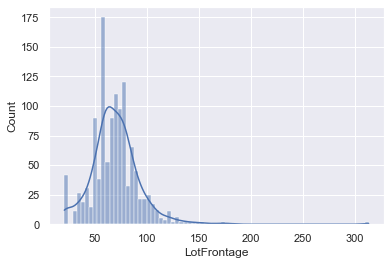

In [11]:
# For numerical Check distirbution of values
sns.histplot(house_df.LotFrontage,kde=True)
plt.show()

In [12]:
# Based on best assumption we replace NaN with median value
house_df.LotFrontage.replace(np.nan,house_df.LotFrontage.median(),inplace=True)
# check for null
house_df.LotFrontage.isnull().sum()
0

0

#### Impute FireplaceQu NaN values

In [13]:
# Percentage of NaN values
print(house_df.FireplaceQu.isnull().sum()/house_df.shape[0]*100)

47.26027397260274


In [14]:
# Check if Numerical or Categorical variable 
house_df.FireplaceQu.value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [15]:
# As categorical add a new category value - no_value
house_df.FireplaceQu.replace(np.nan,'no_value',inplace=True)
# check
house_df.FireplaceQu.value_counts()

no_value    690
Gd          380
TA          313
Fa           33
Ex           24
Po           20
Name: FireplaceQu, dtype: int64

#### Impute Masonry veneer variable NaN values

In [16]:
masonary_cols=house_df.filter(like='MasVnr', axis=1)
for i in masonary_cols:
    print(i)
    print("Percentage missing:")
    print(house_df[i].isnull().sum()/house_df.shape[0]*100)
    print("Index of missing records:")
    print(house_df[house_df[i].isnull()].index)
    print()

MasVnrType
Percentage missing:
0.547945205479452
Index of missing records:
Int64Index([234, 529, 650, 936, 973, 977, 1243, 1278], dtype='int64')

MasVnrArea
Percentage missing:
0.547945205479452
Index of missing records:
Int64Index([234, 529, 650, 936, 973, 977, 1243, 1278], dtype='int64')



In [17]:
# As the missing values from same record and is 0.54 % we can remove these records
house_df.dropna(subset = ['MasVnrType', 'MasVnrArea'],inplace=True)
# Check records
house_df.shape

(1452, 56)

#### Impute Basement related variables NaN values

In [18]:
# check the variables for null and Check if Numerical or Categorical variable 
basement_cols=house_df.filter(like='Bsmt', axis=1)
for i in basement_cols:
    if (house_df[i].isnull().sum() >0):
        print(i)
        print("Percentage missing:")
        print(house_df[i].isnull().sum()/house_df.shape[0]*100)
        print("Index of missing records:")
        print(house_df[house_df[i].isnull()].index)
        print("Value_Counts:")
        print(house_df[i].value_counts())
        
        print()

BsmtQual
Percentage missing:
2.5482093663911844
Index of missing records:
Int64Index([  17,   39,   90,  102,  156,  182,  259,  342,  362,  371,  392,
             520,  532,  533,  553,  646,  705,  736,  749,  778,  868,  894,
             897,  984, 1000, 1011, 1035, 1045, 1048, 1049, 1090, 1179, 1216,
            1218, 1232, 1321, 1412],
           dtype='int64')
Value_Counts:
TA    648
Gd    612
Ex    120
Fa     35
Name: BsmtQual, dtype: int64

BsmtExposure
Percentage missing:
2.6170798898071626
Index of missing records:
Int64Index([  17,   39,   90,  102,  156,  182,  259,  342,  362,  371,  392,
             520,  532,  533,  553,  646,  705,  736,  749,  778,  868,  894,
             897,  948,  984, 1000, 1011, 1035, 1045, 1048, 1049, 1090, 1179,
            1216, 1218, 1232, 1321, 1412],
           dtype='int64')
Value_Counts:
No    946
Av    221
Gd    133
Mn    114
Name: BsmtExposure, dtype: int64

BsmtFinType1
Percentage missing:
2.5482093663911844
Index of missing records

#### Findings
- we have 2 additional records in BsmtExposure and BsmtFinType2
- All NaN columns are categorical variable

In [19]:
# Dropping the 2 additional records(rows)
house_df.drop(index=[332,948], inplace=True)
# check rows
house_df.shape

(1450, 56)

In [20]:
# As all are categorical we add a new categorical value - No Basement(mentioned in dictionary file)
#basement_cols=house_df.filter(like='Bsmt', axis=1)
for i in basement_cols:
    if (house_df[i].isnull().sum() >0):
        house_df[i].replace(np.nan,'No Basement',inplace=True)
        # check 'No Basement' count
        print(house_df[i].value_counts())
        print()

TA             648
Gd             610
Ex             120
No Basement     37
Fa              35
Name: BsmtQual, dtype: int64

No             945
Av             221
Gd             133
Mn             114
No Basement     37
Name: BsmtExposure, dtype: int64

Unf            427
GLQ            412
ALQ            220
BLQ            148
Rec            132
LwQ             74
No Basement     37
Name: BsmtFinType1, dtype: int64

Unf            1247
Rec              54
LwQ              46
No Basement      37
BLQ              33
ALQ              19
GLQ              14
Name: BsmtFinType2, dtype: int64



#### Impute Garage related variables NaN values

In [21]:
# check the variables for null and Check if Numerical or Categorical variable
# GarageYrBlt is exception as it contains numerical values
garage_cols=house_df.filter(like='Garage', axis=1)
for i in garage_cols:
    if (house_df[i].isnull().sum() >0) & (i != 'GarageYrBlt'):
        print(i)
        print("Percentage missing:")
        print(house_df[i].isnull().sum()/house_df.shape[0]*100)
        print("Index of missing records:")
        print(house_df[house_df[i].isnull()].index)
        print("Value_Counts:")
        print(house_df[i].value_counts())
        
        print()

GarageType
Percentage missing:
5.586206896551724
Index of missing records:
Int64Index([  39,   48,   78,   88,   89,   99,  108,  125,  127,  140,  148,
             155,  163,  165,  198,  210,  241,  250,  287,  291,  307,  375,
             386,  393,  431,  434,  441,  464,  495,  520,  528,  533,  535,
             562,  582,  613,  614,  620,  635,  636,  638,  649,  705,  710,
             738,  750,  784,  826,  843,  921,  942,  954,  960,  968,  970,
             976, 1009, 1011, 1030, 1038, 1096, 1123, 1131, 1137, 1143, 1173,
            1179, 1218, 1219, 1234, 1257, 1283, 1323, 1325, 1326, 1337, 1349,
            1407, 1449, 1450, 1453],
           dtype='int64')
Value_Counts:
Attchd     861
Detchd     387
BuiltIn     87
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

GarageFinish
Percentage missing:
5.586206896551724
Index of missing records:
Int64Index([  39,   48,   78,   88,   89,   99,  108,  125,  127,  140,  148,
             155,  163,  

#### Findings
- All NaN columns are categorical variable except GarageYrBlt
- 'No Garage' to be used(mentioned in the dictionary)

In [22]:
# As all are categorical we add a new categorical value - No Garage(mentioned in dictionary file)
for i in garage_cols:
    if (house_df[i].isnull().sum() >0) & (i != 'GarageYrBlt'):
        house_df[i].replace(np.nan,'No Garage',inplace=True)
        # check 'No Garage' count
        print(house_df[i].value_counts())
        print()

Attchd       861
Detchd       387
BuiltIn       87
No Garage     81
Basment       19
CarPort        9
2Types         6
Name: GarageType, dtype: int64

Unf          605
RFn          416
Fin          348
No Garage     81
Name: GarageFinish, dtype: int64



#### Derive variable Age of property
- Age of propety is an important factor influencing price(may depriciate).
- YrSold and YearBuilt can be used this new variable- age

In [23]:
house_df['Age']=house_df.YrSold-house_df.YearBuilt
# Look into Property age spread 
house_df.Age.describe()

count    1450.000000
mean       36.742759
std        30.240045
min         0.000000
25%         8.000000
50%        35.000000
75%        54.750000
max       136.000000
Name: Age, dtype: float64

In [24]:
# Check NaN impution done and dataset
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 57 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1450 non-null   int64  
 1   MSZoning       1450 non-null   object 
 2   LotFrontage    1450 non-null   float64
 3   LotArea        1450 non-null   int64  
 4   LotShape       1450 non-null   object 
 5   LandContour    1450 non-null   object 
 6   LotConfig      1450 non-null   object 
 7   Neighborhood   1450 non-null   object 
 8   Condition1     1450 non-null   object 
 9   BldgType       1450 non-null   object 
 10  HouseStyle     1450 non-null   object 
 11  OverallQual    1450 non-null   int64  
 12  OverallCond    1450 non-null   int64  
 13  YearBuilt      1450 non-null   int64  
 14  YearRemodAdd   1450 non-null   int64  
 15  RoofStyle      1450 non-null   object 
 16  Exterior1st    1450 non-null   object 
 17  Exterior2nd    1450 non-null   object 
 18  MasVnrTy

#### Summary dataset after Data cleaning stage
- 1450 records, 57 colums and no NaN

#### Identify numeric and Categorical variable

In [25]:
'''
Checking if a column can be treated as numerical or categorical variable.
Few of the numerical columns for instance have ordinality but are not continious for this analysis so we have treated it as a categorical variable. 
 Rule: Treat a column as categorical, if the maximum number of unique values  is less than 26 or else its treated as continous numeric.
Create array of variables for  categorical and numerical
'''
def func_variable_type(dtf, col, max_cat):
    if (dtf[col].nunique() < max_cat):
        cat_list.append(col)       
    else:
        num_list.append(col)
#    print(col,dtf[col].nunique())

In [26]:
#Call function func_varable_type and print categorical and numeric variable 
cat_list=[]
num_list=[]
dic_cols = {col:func_variable_type(house_df, col, max_cat=26) for col in house_df.columns}
# Print the variable 
print("Categorial variable :", cat_list)
print()
print("Numeric variable :", num_list)

Categorial variable : ['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

Numeric variable : ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'SalePrice', 'Age']


#### Univariant and Multivariant Analysis

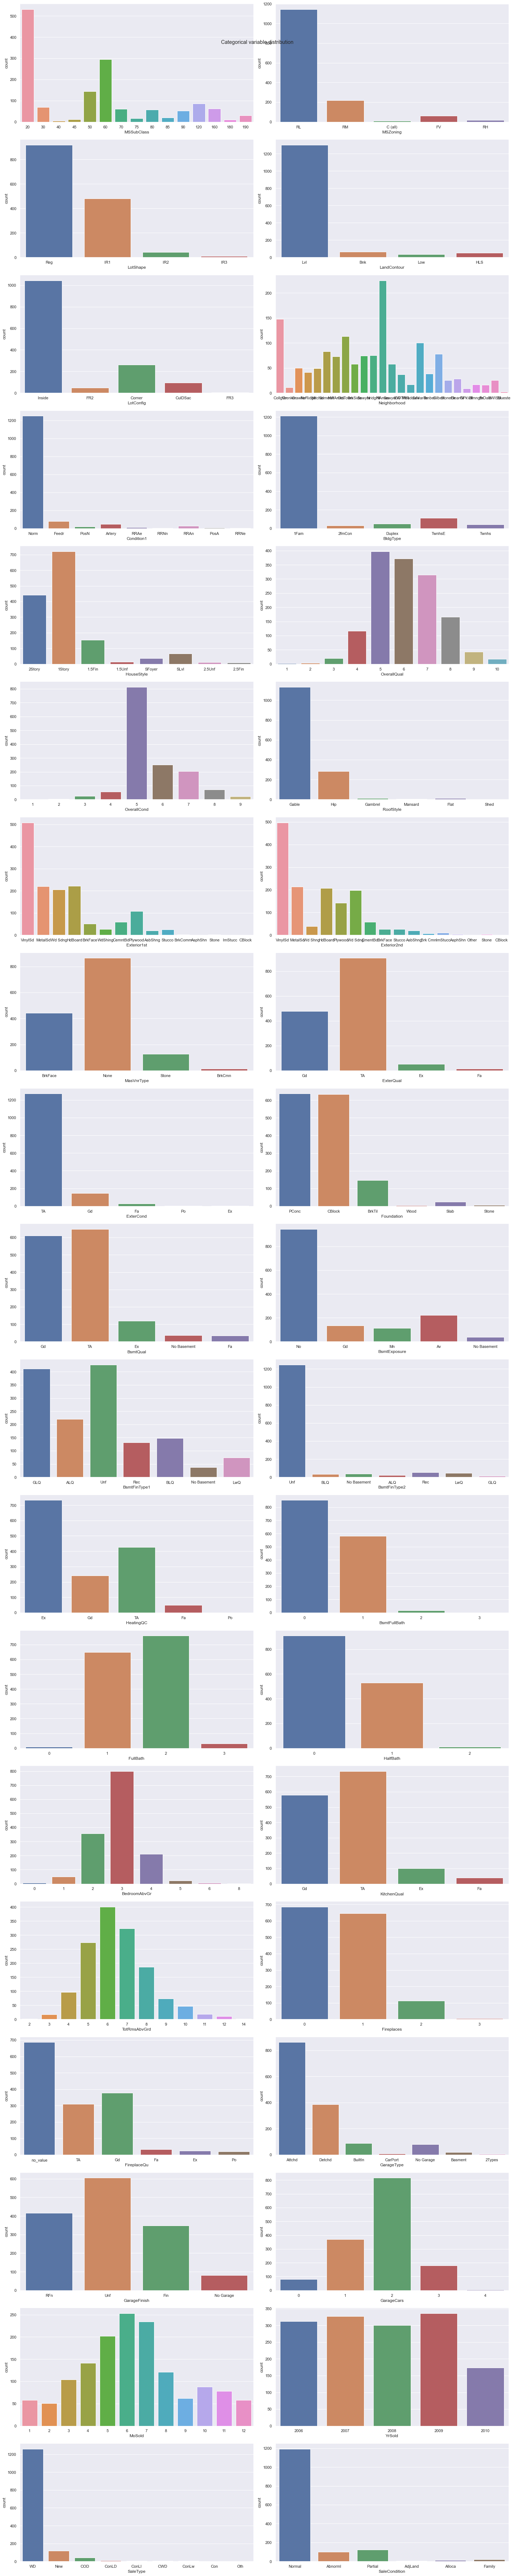

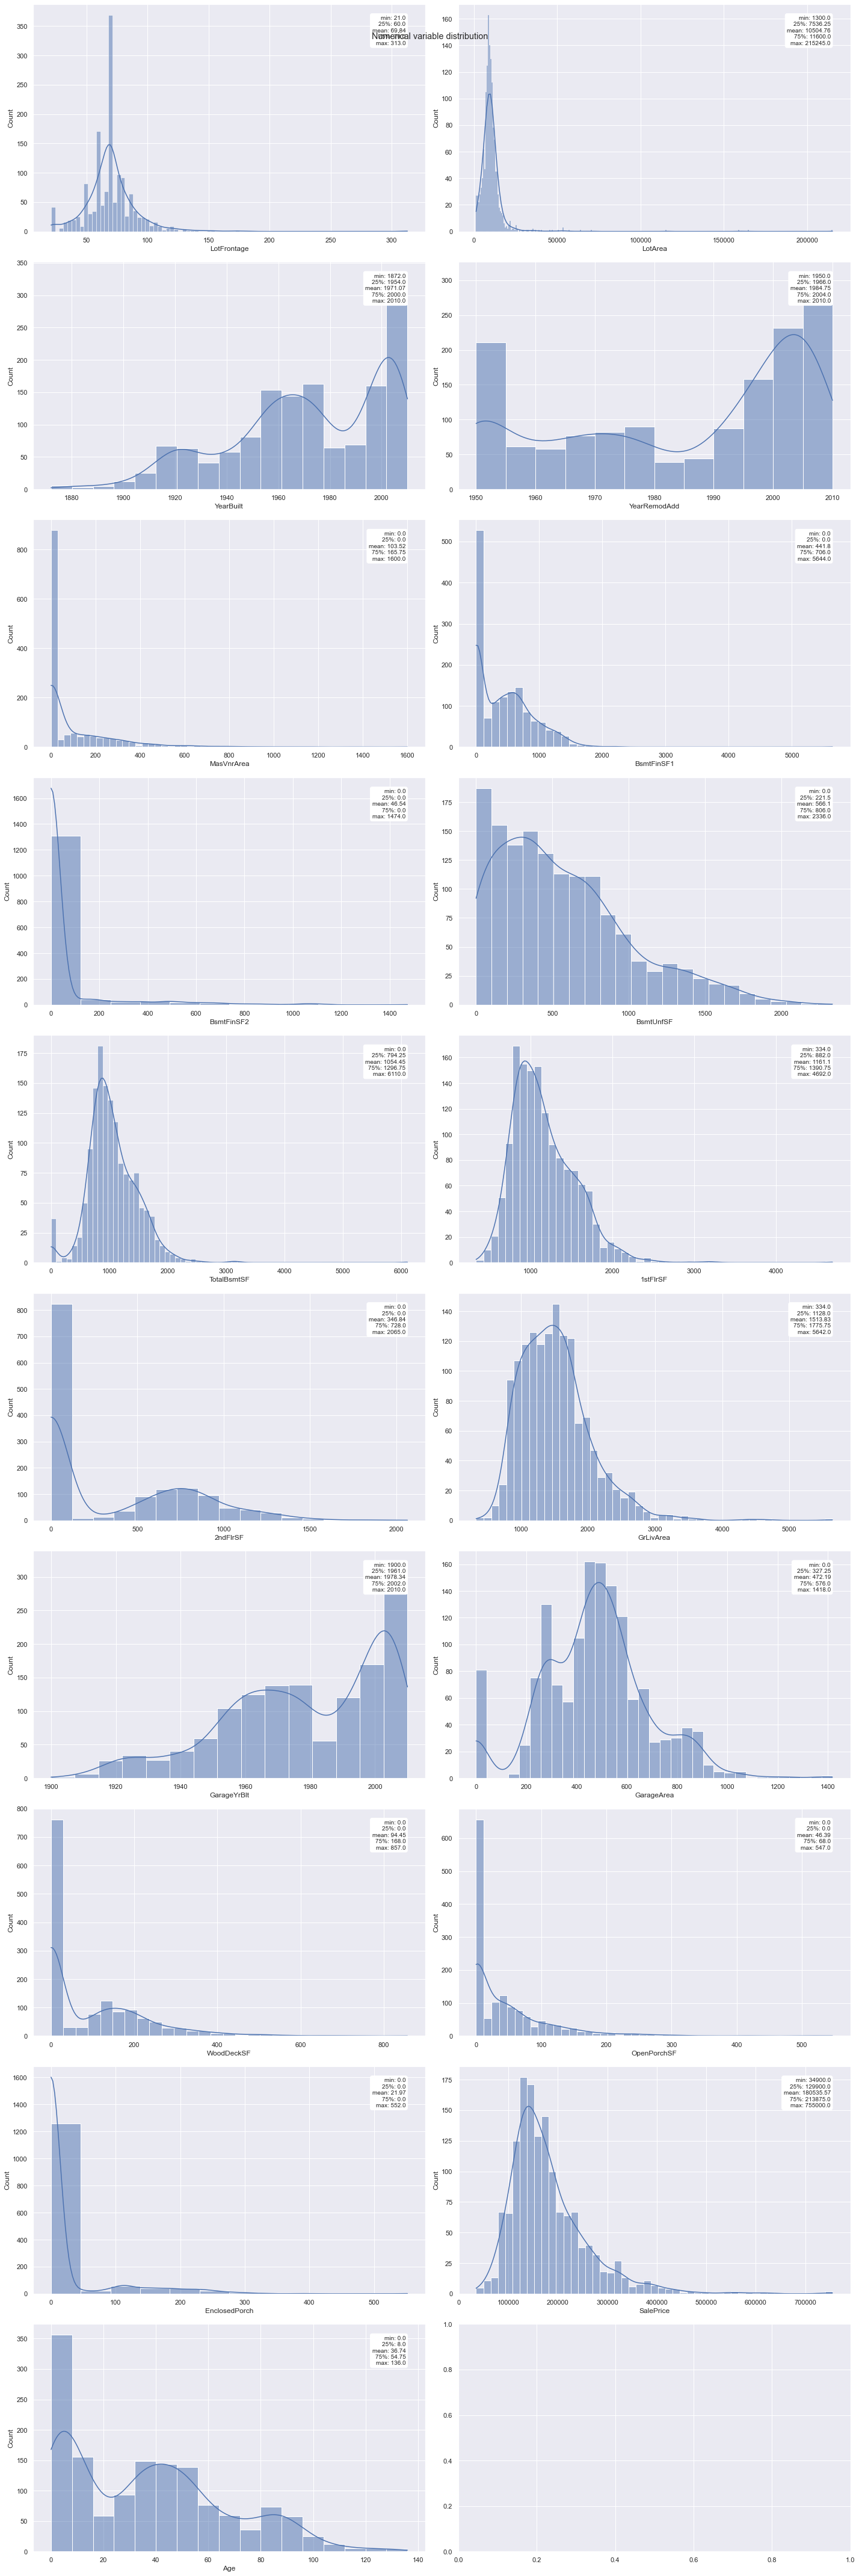

In [27]:
#Univariant analysis
#Subplot
fig,axs = plt.subplots(19,2,figsize=(20,100))
fig.suptitle('Categorical variable distribution')
axs = axs.flat
totals= []
for ax,column in zip(axs,cat_list):
    sns.countplot(x=house_df[column],ax=ax)
plt.tight_layout()



fig,axs = plt.subplots(10,2,figsize=(20,60))
fig.suptitle('Numerical variable distribution')
axs = axs.flat
for ax, column in zip(axs, num_list):
    sns.histplot(house_df[column],kde=True,ax=ax)
    desc = house_df[column].describe()
    desc = round(desc, 2).apply(lambda x: str(x))
    box = '\n'.join(("min: "+desc["min"], "25%: "+desc["25%"], "mean: "+desc["mean"], "75%: "+desc["75%"], "max: "+desc["max"]))
    ax.text(0.95, 0.95, box, transform=ax.transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
plt.tight_layout()

#### Key Findings
- Target variable 'SalePrice' is right skewed in the distribution. Most of the property value lies in range of 100000-250000. This is followed by a long right tail.
- Outliers of .25 and .75 are shown for numerical variable.

<AxesSubplot:xlabel='SalePrice'>

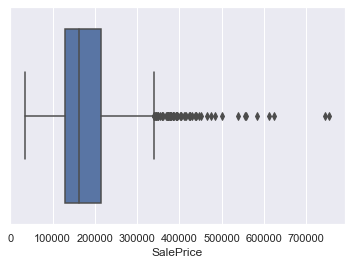

In [28]:
# Checking the outliers for Sales Price
sns.boxplot(x='SalePrice', data=house_df)

In [29]:
print("SalePrice Skewness: %f" % house_df['SalePrice'].skew())

SalePrice Skewness: 1.887588


Text(0.5, 1.0, 'After transformation- SalesPrice')

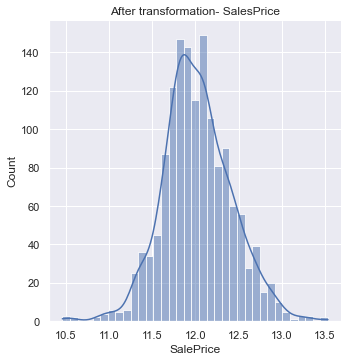

In [30]:
# Power Transform the SalePrice
#Distribution of 'log(SalePrice)' 
sns.displot(np.log(house_df['SalePrice']),kde=True)
plt.title('After transformation- SalesPrice')

# Apply the transform in data preparation

##### Scatterplot for all numerical variables vs SalePrice

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'SalePrice', 'Age']


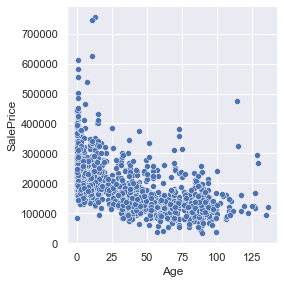

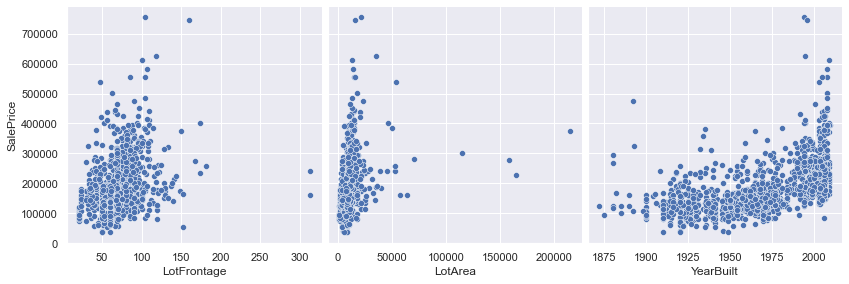

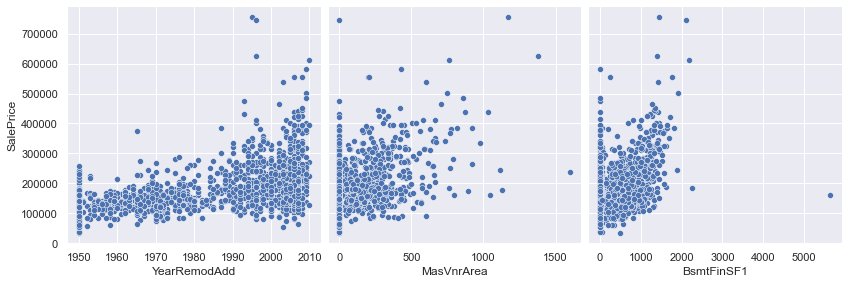

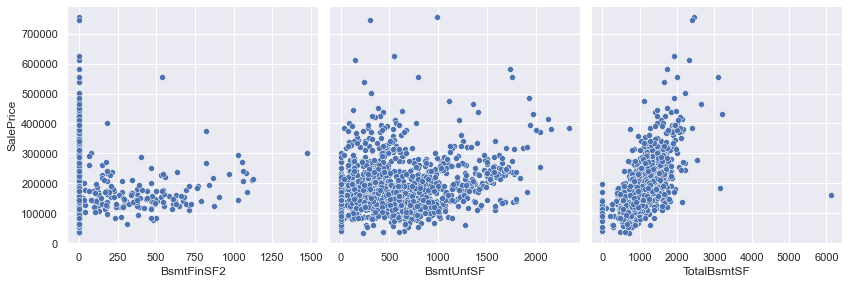

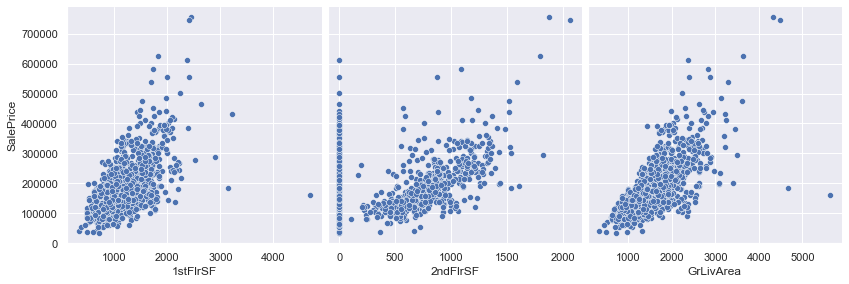

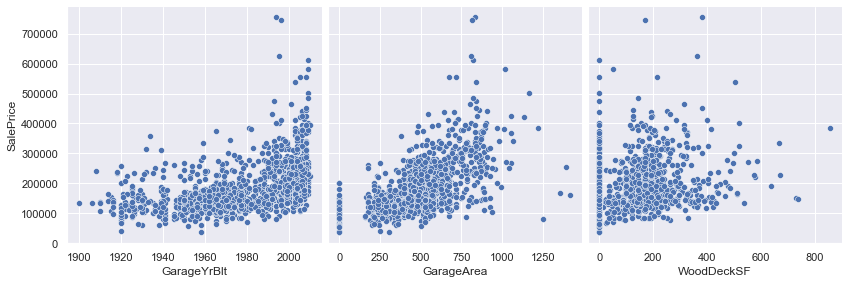

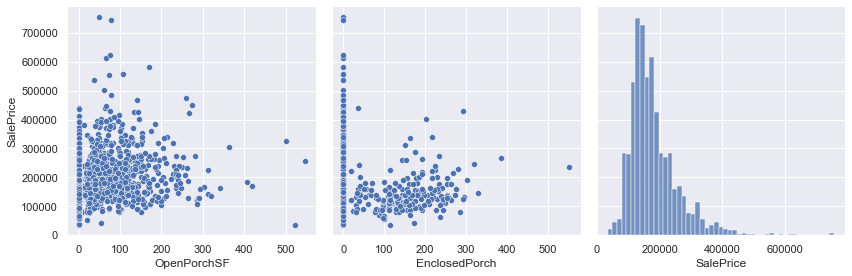

In [31]:
# Adding category variable as legends
# Scatterplot for numerical variable 
numvar_df = house_df[num_list]
print(num_list)
j=0
sns.pairplot(numvar_df,x_vars=['Age'] ,y_vars=['SalePrice'], height = 4)
for i in range(3, len(num_list)+2,3):
    sns.pairplot(numvar_df,x_vars=num_list[j:i] ,y_vars=['SalePrice'], height = 4)
    j=i
plt.tight_layout()

Text(0.5, 1.0, 'Look into Correlation matrix ')

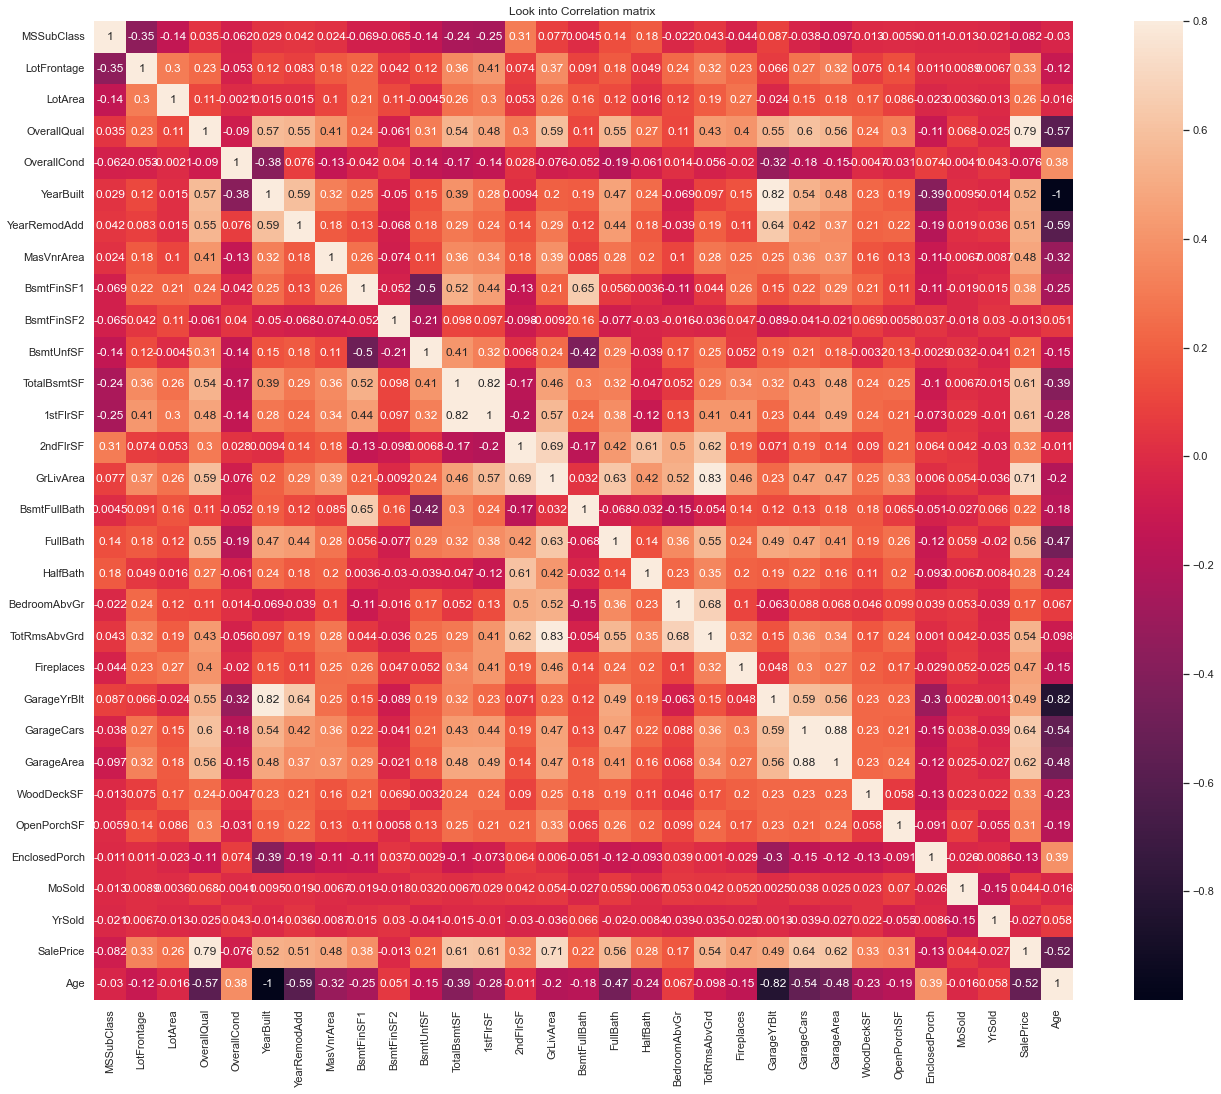

In [32]:
#checking the correlation matrix
corr = house_df.corr()
f, ax = plt.subplots(figsize=(22, 18))
sns.heatmap(corr, vmax=.8, square=True, annot=True);
plt.title("Look into Correlation matrix ")

#### Observation
Top features positively correlated to SalePrice: 
- OverallQual
- YearBuilt
- YearRemodAdd
- TotalBsmtSF
- 1stFlrSF
- GrLivArea
- FullBath
- TotRmsAbvGrd
- GarageCars
- GarageArea

Top Feature negativly correlated to SalePrice:
- Age

Highly correlated independent variable(more than 80%):
- GarageCars to GarageArea, 88%
- TotRmsAbvGrd to GrLivArea, 83%
- GarageYrBlt to YearBuilt, 82%
- TotalBsmtSF to 1stFlrSF, 82%
- YearBuilt to Age, -100%
- GarageYrBlt to Age, -82%

#### Also Observation from scatterplot:
GrLivArea-
       - More the Ground Living Area more the price. 

In [33]:
# Removing one of highly correlated variables from dataset and catgorical list and numerical list
remove_cols = ['GarageArea','TotRmsAbvGrd','GarageYrBlt','1stFlrSF','YearBuilt']
house_df.drop(remove_cols, axis=1,inplace=True)

#Also remove cols from catgorical list and numerical list
unwanted_num = {'GarageArea','TotRmsAbvGrd','GarageYrBlt','1stFlrSF','YearBuilt'}
cat_list=[ele for ele in cat_list if ele not in unwanted_num]
num_list=[ele for ele in num_list if ele not in unwanted_num]

# Print the variable 
print("New Categorial variable :", cat_list)
print()
print("New Numeric variable :", num_list)

New Categorial variable : ['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

New Numeric variable : ['LotFrontage', 'LotArea', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'SalePrice', 'Age']


#### All categorical variable to sales price- Bivariant Analysis

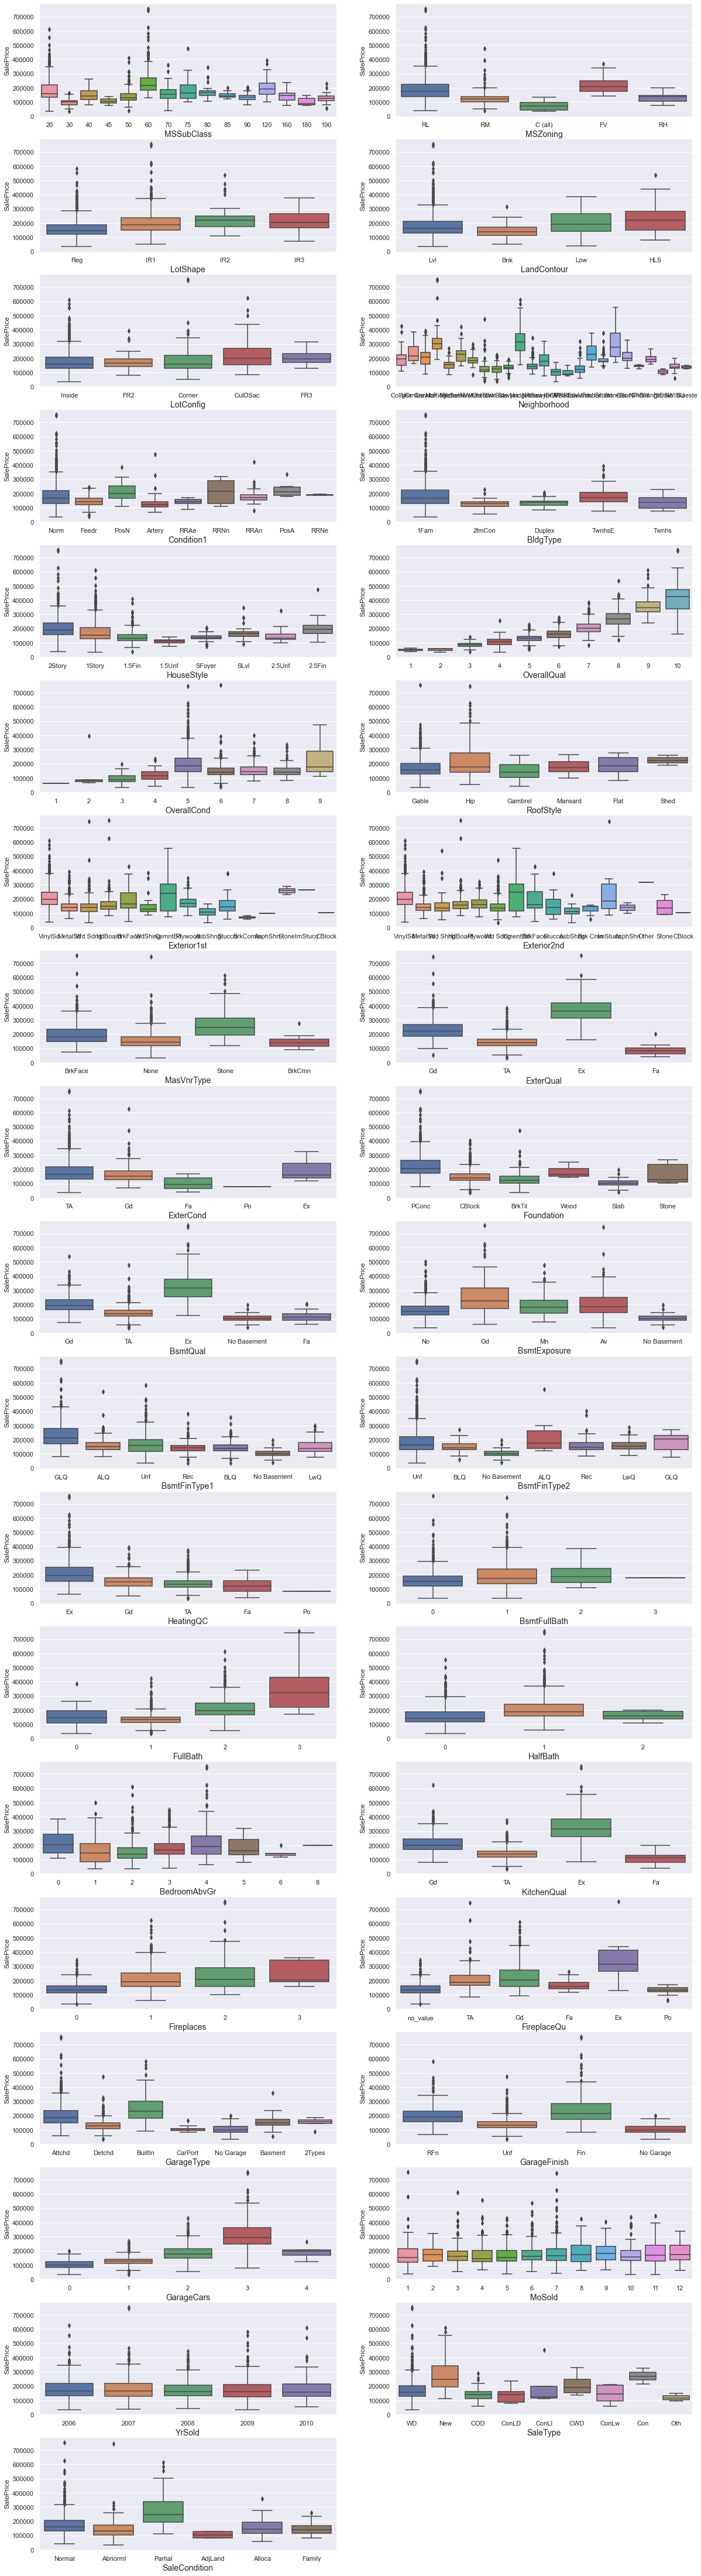

In [34]:
plt.figure(figsize=(20,80))
for m,n in enumerate(cat_list):
    plt.subplot(19,2,(m+1))
    sns.boxplot(x=n, y='SalePrice',data=house_df)
    plt.xlabel(n, fontsize=14)
plt.show()

#### Observation: 
- Overall Quality, FirePlaces:
    - The plot shows that as OverallQual and Fireplace increases, the SalePrice also increases.
    - This is true on normally as OverallQual is more the SalePrice is also more.
    - This is a categorical ordered variable 
- GarageCars: 
    - Over all we see similar trend showing incraese in GarageCars also increases SalePrice.
    - Except the plot shows Garage of 3 has higher SalePrice, even more than Garage of 4.
- Identifying ordered categorical variable which later will be converted to numerical
    - OverallQual,FirePlaces, LotShape, ExterQual, BsmtQual, BsmtExposure, BsmtFinType1, HeatingQC, KitchenQual, FireplaceQu, GarageFinish
    - Its best to convert them into numerical variables instead of creating dummy variables.
    - In constrast to above categorial variable, we are not mapping few variables - YrSold, MoSold,etc. For these variables we are not correlating count with increase/decrease in variable values- so we will use Dummy variable encoding later to convert to numeric variables.

In [35]:
#Mapping ordered categorial variables as per metadata description.
# OverallQual - No mapping required only move it to num_list

# FirePlaces - No mapping required only move it to num_list

# LotShape - mapped based on data dictionary
house_df['LotShape']=house_df['LotShape'].map({'Reg':3,'IR1':2,'IR2':1,'IR3':0})

# ExterQual - mapped based on data dictionary
house_df['ExterQual']=house_df['ExterQual'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})

# BsmtQual - mapped based on data dictionary
house_df['BsmtQual']=house_df['BsmtQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No Basement':0})

# BsmtExposure - mapped based on data dictionary
house_df['BsmtExposure']=house_df['BsmtExposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1,'No Basement':0})

# BsmtFinType1 - mapped based on data dictionary
house_df['BsmtFinType1']=house_df['BsmtFinType1'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'No Basement':0})

# HeatingQC - mapped based on data dictionary
house_df['HeatingQC']=house_df['HeatingQC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})

# KitchenQual - mapped based on data dictionary
house_df['KitchenQual']=house_df['KitchenQual'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})

# FireplaceQu - mapped based on data dictionary
house_df['FireplaceQu']=house_df['FireplaceQu'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'no_value':0})

# GarageFinish - mapped based on data dictionary
house_df['GarageFinish']=house_df['GarageFinish'].map({'Fin':3,'RFn':2,'Unf':1,'No Garage':0})

# remove these variables from oredered categorical varilable cat_list(renamed to unord_cat_list )
ord_cat_list = {'OverallQual','FirePlaces', 'LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish'}
unord_cat_list=[ele for ele in cat_list if ele not in unwanted_num]

# Print the unordered variable list 
print("Unordered Categorial variables :", unord_cat_list)

Unordered Categorial variables : ['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


## 2. Feature Engineering

#### LogTransform SalePrice

In [36]:
# Apply log tranform to normalize the distribution of SalePrice
house_df['SalePrice']=np.log(house_df['SalePrice'])
# Check skewness
print("SalePrice Skewness: %f" % house_df['SalePrice'].skew())

SalePrice Skewness: 0.123944


#### For Unordered Categorical values
- create dummy variables


In [37]:
cat_df=house_df[unord_cat_list]
cat_df.head()

,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,KitchenQual,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,3,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,...,3,0,0,Attchd,2,2,2,2008,WD,Normal
1,20,RL,3,Lvl,FR2,Veenker,Feedr,1Fam,1Story,6,...,2,1,3,Attchd,2,2,5,2007,WD,Normal
2,60,RL,2,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,...,3,1,3,Attchd,2,2,9,2008,WD,Normal
3,70,RL,2,Lvl,Corner,Crawfor,Norm,1Fam,2Story,7,...,3,1,4,Detchd,1,3,2,2006,WD,Abnorml
4,60,RL,2,Lvl,FR2,NoRidge,Norm,1Fam,2Story,8,...,3,1,3,Attchd,2,3,12,2008,WD,Normal


In [38]:
# covert to dummy variables
dummies_df = pd.get_dummies(cat_df, drop_first=True)
dummies_df.head()

,MSSubClass,LotShape,OverallQual,OverallCond,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,BsmtFullBath,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,3,7,5,3,4,1,6,4,1,...,0,0,0,0,1,0,0,0,1,0
1,20,3,6,8,2,4,4,5,4,0,...,0,0,0,0,1,0,0,0,1,0
2,60,2,7,5,3,4,2,6,4,1,...,0,0,0,0,1,0,0,0,1,0
3,70,2,7,5,2,3,1,5,3,1,...,0,0,0,0,1,0,0,0,0,0
4,60,2,8,5,3,4,3,6,4,1,...,0,0,0,0,1,0,0,0,1,0


In [39]:
# Drop the original categorical column
house_df.drop(unord_cat_list, axis=1,inplace=True)

In [40]:
# Add the dummy categorical column to original dataset
house_df = pd.concat([house_df,dummies_df], axis=1)
#check
house_df.shape

(1450, 160)

## 3. Modeling
### Supervised learning
* The y variable is SalePrice. This is what we need to predict.

### Train-Test split

In [41]:
# Create training and testing sets: with 75-25% split with no rows repeating in both set.
df_train, df_test= model_selection.train_test_split(house_df,train_size=0.25,random_state=50)

### Scale the feature
* As this is a regression problems, best practice is to scale both input and target variables
* MinMaxScaler is used

In [42]:
scaler=MinMaxScaler()
df_train_trans=scaler.fit_transform(df_train)
#convert the scalled array into dataframe
df_train_trans=pd.DataFrame(df_train_trans, columns=df_train.columns)
df_test_trans=scaler.transform(df_test)
#convert the scalled array into dataframe
df_test_trans=pd.DataFrame(df_test_trans, columns=df_test.columns)

#### Spliting y variable from data

In [43]:
y_train = df_train_trans['SalePrice']
X_train = df_train_trans.drop('SalePrice',axis=1)
y_test = df_test_trans['SalePrice']
X_test = df_test_trans.drop('SalePrice',axis=1)

In [44]:
#### Base Model - LR
lm = LinearRegression()
lm.fit(X_train,y_train)
y_train_pred= lm.predict(X_train)
y_test_pred= lm.predict(X_test)
print('train R2 score is',(r2_score(y_train,y_train_pred)))
print('test R2 score is',(r2_score(y_test,y_test_pred)))

train R2 score is 0.9337728188801259
test R2 score is -9.019381062626764e+22


#### Model with Ridge regression:

In [45]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500 ]}

ridge = Ridge()

# cross validation
folds = 5

model_cv = GridSearchCV(estimator = ridge, param_grid = params, scoring= 'neg_mean_absolute_error',
                        cv = folds, return_train_score=True, verbose = 1)            
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [46]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=100]
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006202,9.820808e-04,0.003801,1.167393e-03,0.0001,{'alpha': 0.0001},-0.039452,-0.050408,-0.053591,-0.053914,...,-0.049821,0.005339,24,-0.024784,-0.016789,-0.022640,-0.022562,-0.022759,-0.021907,0.002689
1,0.005399,1.018786e-03,0.003206,1.474927e-03,0.001,{'alpha': 0.001},-0.039390,-0.050361,-0.053377,-0.053729,...,-0.049675,0.005288,23,-0.024794,-0.016792,-0.022656,-0.022564,-0.022764,-0.021914,0.002692
2,0.003400,7.996560e-04,0.002800,7.478314e-04,0.01,{'alpha': 0.01},-0.039119,-0.049930,-0.051774,-0.052398,...,-0.048596,0.004848,22,-0.024901,-0.016836,-0.022817,-0.022596,-0.022829,-0.021996,0.002713
3,0.004221,1.181680e-03,0.002379,8.121509e-04,0.05,{'alpha': 0.05},-0.039498,-0.048604,-0.048554,-0.050531,...,-0.046789,0.003836,21,-0.025307,-0.017064,-0.023359,-0.022925,-0.023205,-0.022372,0.002785
4,0.004200,3.994945e-04,0.002801,7.491311e-04,0.1,{'alpha': 0.1},-0.039370,-0.047604,-0.046967,-0.049581,...,-0.045722,0.003485,20,-0.025659,-0.017363,-0.023887,-0.023247,-0.023659,-0.022763,0.002823
5,0.003585,5.099601e-04,0.002400,4.903881e-04,0.2,{'alpha': 0.2},-0.038499,-0.046845,-0.045006,-0.048522,...,-0.044393,0.003460,18,-0.026193,-0.017983,-0.024563,-0.023657,-0.024444,-0.023368,0.002816
6,0.003800,1.165787e-03,0.003000,6.319576e-04,0.3,{'alpha': 0.3},-0.037852,-0.046469,-0.043653,-0.047891,...,-0.043528,0.003549,17,-0.026555,-0.018550,-0.025066,-0.023975,-0.025012,-0.023832,0.002766
7,0.004199,3.990424e-04,0.002201,3.996872e-04,0.4,{'alpha': 0.4},-0.037242,-0.046290,-0.042852,-0.047408,...,-0.042950,0.003676,16,-0.026837,-0.019029,-0.025473,-0.024243,-0.025456,-0.024208,0.002716
8,0.003801,3.991389e-04,0.002200,4.003525e-04,0.5,{'alpha': 0.5},-0.036688,-0.046186,-0.042226,-0.046992,...,-0.042504,0.003793,15,-0.027072,-0.019452,-0.025808,-0.024498,-0.025814,-0.024529,0.002666
9,0.004200,1.166327e-03,0.002799,7.481008e-04,0.6,{'alpha': 0.6},-0.036156,-0.046137,-0.041701,-0.046649,...,-0.042151,0.003910,13,-0.027297,-0.019855,-0.026101,-0.024732,-0.026112,-0.024819,0.002612


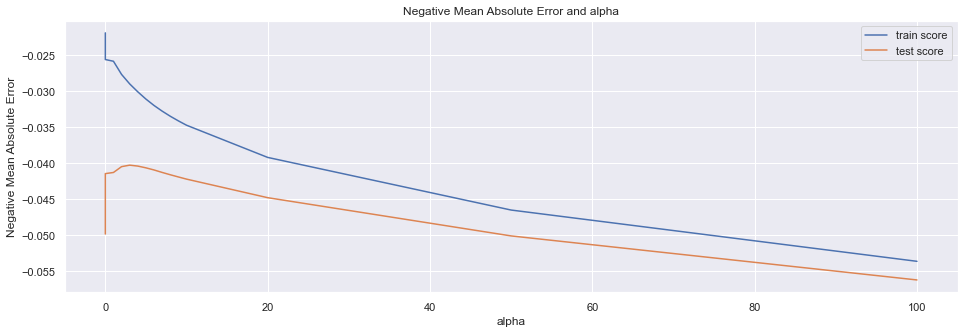

In [47]:
# plot mean test and train scores with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')
plt.figure(figsize=(16,5))

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [48]:
print(model_cv.best_params_)
print(model_cv.best_score_)

{'alpha': 3.0}
-0.04026216190807538


#### Observation for Ridge
- from the plot and the bestparam score we got optimum alpha to be 3

In [49]:
### Question 1,2

In [50]:
alph = 3
ridge = Ridge(alpha=alph)

ridge.fit(X_train, y_train)
ridge.coef_

array([-0.00900693,  0.02866082,  0.04251056,  0.01806223,  0.00303707,
        0.00481096,  0.02106731,  0.01162532,  0.05377492,  0.0562816 ,
        0.01242283,  0.02435241, -0.00067572, -0.00745581, -0.02184179,
        0.00378011,  0.10492808,  0.07184179,  0.03637715,  0.04078236,
        0.02475088,  0.02762628,  0.02109553,  0.02622642,  0.06959677,
        0.02372496,  0.05186756,  0.03241685,  0.01895218,  0.0372752 ,
        0.0094638 ,  0.0813704 , -0.01369808,  0.00681514,  0.02205058,
        0.02460318,  0.02785434,  0.00741781, -0.00828542,  0.01000105,
       -0.00171602,  0.03296313, -0.01813059,  0.        , -0.00935895,
        0.        ,  0.0002383 ,  0.0239816 ,  0.04348354, -0.01739326,
        0.03795475, -0.03983135, -0.02109726, -0.06372726, -0.03289127,
       -0.01310379,  0.00079012,  0.00063655,  0.00042752,  0.02141635,
        0.03488444, -0.00491463,  0.00812209, -0.00636921, -0.01335701,
        0.01940503,  0.04992579,  0.00279792,  0.02289209, -0.03

In [51]:
# Putting all the variables and coefficients after ridge regression
ridge_dict=dict(zip(X_train.columns,ridge.coef_))
#filter dictionary for only non-zero coefficients
final_dict={}
for i in ridge_dict:
    if ridge_dict[i]!=0:
        final_dict[i]= round(ridge_dict[i],3)
final_dict

{'LotFrontage': -0.009,
 'LotArea': 0.029,
 'YearRemodAdd': 0.043,
 'MasVnrArea': 0.018,
 'BsmtFinSF1': 0.003,
 'BsmtFinSF2': 0.005,
 'BsmtUnfSF': 0.021,
 'TotalBsmtSF': 0.012,
 '2ndFlrSF': 0.054,
 'GrLivArea': 0.056,
 'WoodDeckSF': 0.012,
 'OpenPorchSF': 0.024,
 'EnclosedPorch': -0.001,
 'Age': -0.007,
 'MSSubClass': -0.022,
 'LotShape': 0.004,
 'OverallQual': 0.105,
 'OverallCond': 0.072,
 'ExterQual': 0.036,
 'BsmtQual': 0.041,
 'BsmtExposure': 0.025,
 'BsmtFinType1': 0.028,
 'HeatingQC': 0.021,
 'BsmtFullBath': 0.026,
 'FullBath': 0.07,
 'HalfBath': 0.024,
 'BedroomAbvGr': 0.052,
 'KitchenQual': 0.032,
 'Fireplaces': 0.019,
 'FireplaceQu': 0.037,
 'GarageFinish': 0.009,
 'GarageCars': 0.081,
 'MoSold': -0.014,
 'YrSold': 0.007,
 'MSZoning_FV': 0.022,
 'MSZoning_RH': 0.025,
 'MSZoning_RL': 0.028,
 'MSZoning_RM': 0.007,
 'LandContour_HLS': -0.008,
 'LandContour_Low': 0.01,
 'LandContour_Lvl': -0.002,
 'LotConfig_CulDSac': 0.033,
 'LotConfig_FR2': -0.018,
 'LotConfig_Inside': -0.009,


In [52]:
# the R-squared value of test and train data
y_train_pred = ridge.predict(X_train)
print(r2_score(y_true=y_train, y_pred=y_train_pred))

y_train_pred = ridge.predict(X_test)
print(r2_score(y_true=y_test, y_pred=y_test))

0.920232963043601
1.0


In [53]:
# Doubling the alpha
alph = alph*2
print("new Alpha:",alph)
ridge = Ridge(alpha=alph)

ridge.fit(X_train, y_train)
# the R-squared value of test and train data
y_train_pred = ridge.predict(X_train)
print(r2_score(y_true=y_train, y_pred=y_train_pred))

y_train_pred = ridge.predict(X_test)
print(r2_score(y_true=y_test, y_pred=y_test))
print()

ridge.coef_
# Putting all the variables and coefficients after ridge regression
ridge_dict=dict(zip(X_train.columns,ridge.coef_))
#filter dictionary for only non-zero coefficients
final_dict={}
for i in ridge_dict:
    if ridge_dict[i]!=0:
        final_dict[i]= round(ridge_dict[i],3)
final_dict
a = sorted(final_dict.items(), key=lambda x: x[1], reverse=True)    
print(a)

new Alpha: 6
0.9053250514255086
1.0

[('OverallQual', 0.082), ('GarageCars', 0.072), ('FullBath', 0.058), ('OverallCond', 0.055), ('BedroomAbvGr', 0.047), ('YearRemodAdd', 0.045), ('2ndFlrSF', 0.045), ('GrLivArea', 0.044), ('FireplaceQu', 0.04), ('Neighborhood_StoneBr', 0.039), ('ExterQual', 0.037), ('KitchenQual', 0.035), ('BsmtQual', 0.034), ('Neighborhood_Crawfor', 0.031), ('Neighborhood_ClearCr', 0.03), ('LotConfig_CulDSac', 0.029), ('Neighborhood_NridgHt', 0.029), ('BsmtFinType1', 0.028), ('BsmtExposure', 0.024), ('LotArea', 0.023), ('OpenPorchSF', 0.023), ('HeatingQC', 0.023), ('MSZoning_RL', 0.022), ('BsmtFullBath', 0.021), ('BsmtUnfSF', 0.02), ('Fireplaces', 0.02), ('Neighborhood_BrkSide', 0.02), ('HouseStyle_2.5Unf', 0.02), ('HalfBath', 0.019), ('Neighborhood_NoRidge', 0.019), ('Exterior1st_BrkFace', 0.019), ('MasVnrArea', 0.017), ('MSZoning_FV', 0.017), ('MSZoning_RH', 0.016), ('Neighborhood_Somerst', 0.016), ('HouseStyle_1Story', 0.015), ('TotalBsmtSF', 0.014), ('WoodDeckSF'

###### Clearly overfitting issue

#### Model with Lasso regression:

In [54]:
lasso = Lasso()
params = {'alpha': [0.0001, 0.0005, .001 , .005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]}
# cross validation
lasso_model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                   0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0,
                                   10.0]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [55]:
cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.010600,0.001626,0.002452,5.598505e-04,0.0001,{'alpha': 0.0001},-0.036585,-0.047788,-0.040013,-0.045517,...,-0.041803,0.004178,3,-0.027502,-0.020103,-0.026718,-0.025221,-0.026269,-0.025163,0.002635
1,0.005001,0.000633,0.002599,7.994445e-04,0.0005,{'alpha': 0.0005},-0.035215,-0.044656,-0.036775,-0.044379,...,-0.039993,0.003880,1,-0.032350,-0.025714,-0.032210,-0.030893,-0.031799,-0.030593,0.002492
2,0.004800,0.001165,0.002400,4.902152e-04,0.001,{'alpha': 0.001},-0.037288,-0.044878,-0.038943,-0.045759,...,-0.041794,0.003279,2,-0.036259,-0.030910,-0.036713,-0.035730,-0.036011,-0.035125,0.002132
3,0.004600,0.000801,0.003001,8.948467e-04,0.005,{'alpha': 0.005},-0.047600,-0.054893,-0.058825,-0.058412,...,-0.054815,0.004032,4,-0.053004,-0.052259,-0.054419,-0.051541,-0.052724,-0.052790,0.000953
4,0.005200,0.000748,0.003600,1.623522e-03,0.01,{'alpha': 0.01},-0.055275,-0.063529,-0.066287,-0.072950,...,-0.065036,0.005765,5,-0.065301,-0.063211,-0.063901,-0.062914,-0.065137,-0.064093,0.000975
5,0.004799,0.001470,0.002400,7.996093e-04,0.05,{'alpha': 0.05},-0.095404,-0.105804,-0.112325,-0.121194,...,-0.108996,0.008443,6,-0.112477,-0.109767,-0.108169,-0.106046,-0.108754,-0.109042,0.002105
6,0.005200,0.000750,0.004002,1.264749e-03,0.1,{'alpha': 0.1},-0.095404,-0.105804,-0.112325,-0.121194,...,-0.108996,0.008443,6,-0.112477,-0.109767,-0.108169,-0.106046,-0.108754,-0.109042,0.002105
7,0.003800,0.000749,0.002801,4.003091e-04,0.2,{'alpha': 0.2},-0.095404,-0.105804,-0.112325,-0.121194,...,-0.108996,0.008443,6,-0.112477,-0.109767,-0.108169,-0.106046,-0.108754,-0.109042,0.002105
8,0.004601,0.000800,0.002999,8.937236e-04,0.3,{'alpha': 0.3},-0.095404,-0.105804,-0.112325,-0.121194,...,-0.108996,0.008443,6,-0.112477,-0.109767,-0.108169,-0.106046,-0.108754,-0.109042,0.002105
9,0.004399,0.001019,0.003200,7.477806e-04,0.4,{'alpha': 0.4},-0.095404,-0.105804,-0.112325,-0.121194,...,-0.108996,0.008443,6,-0.112477,-0.109767,-0.108169,-0.106046,-0.108754,-0.109042,0.002105


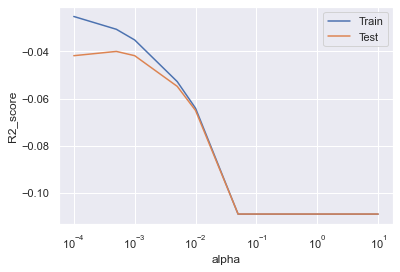

In [56]:
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label='Train')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label='Test')
plt.xlabel('alpha')
plt.ylabel('R2_score')
plt.xscale('log')
plt.legend()
plt.show()

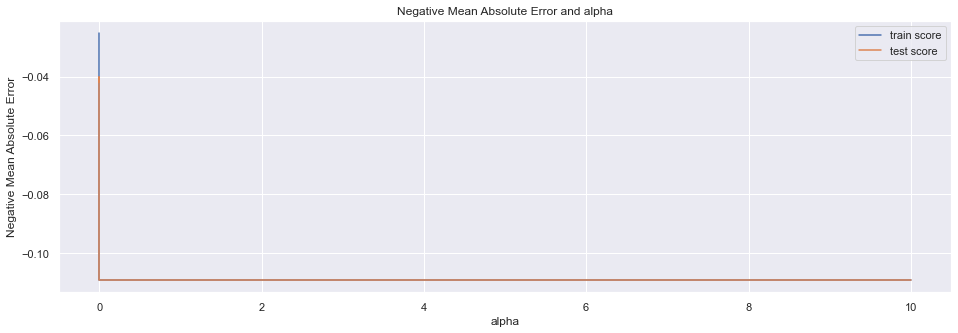

In [57]:
# plot mean test and train scores with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')
plt.figure(figsize=(16,5))

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [58]:
print(lasso_model_cv.best_params_)
print(lasso_model_cv.best_score_)

{'alpha': 0.0005}
-0.03999262068727035


### Question1,2

In [59]:
# trying other alpha values
alph = 0.001
lasso= Lasso(alpha=alph)
lasso.fit(X_train, y_train)
# the R-squared value of test and train data
y_train_pred = lasso.predict(X_train)
print('train R2 score is',round(r2_score(y_train,y_train_pred),2))

y_test_pred= lasso.predict(X_test)
print('test R2 score is',round(r2_score(y_test,y_test_pred),2))

train R2 score is 0.88
test R2 score is 0.83


In [60]:
# double the optimal alpha values
alph = 0.002
lasso= Lasso(alpha=alph)
lasso.fit(X_train, y_train)
# the R-squared value of test and train data
y_train_pred = lasso.predict(X_train)
print('train R2 score is',round(r2_score(y_train,y_train_pred),2))

y_test_pred= lasso.predict(X_test)
print('test R2 score is',round(r2_score(y_test,y_test_pred),2))

# Putting all the variables and coefficients after lasso regression
lasso_dict=dict(zip(X_train.columns,lasso.coef_))
#filter dictionary for only non-zero coefficients
final_dict={}
for i in lasso_dict:
    if lasso_dict[i]!=0:
        final_dict[i]= round(lasso_dict[i],3)
final_dict

b = sorted(final_dict.items(), key=lambda x: x[1],reverse=True)    
print(b)

train R2 score is 0.83
test R2 score is 0.78
[('OverallQual', 0.24), ('GarageCars', 0.12), ('FireplaceQu', 0.064), ('YearRemodAdd', 0.057), ('BedroomAbvGr', 0.04), ('HeatingQC', 0.025), ('BsmtFinType1', 0.022), ('KitchenQual', 0.02), ('FullBath', 0.019), ('MSZoning_RL', 0.018), ('BsmtQual', 0.017), ('GarageType_Attchd', 0.014), ('Foundation_PConc', 0.012), ('LotConfig_CulDSac', 0.007), ('Condition1_Norm', 0.007), ('BsmtExposure', 0.006), ('ExterQual', 0.005), ('GarageFinish', 0.005), ('MasVnrType_BrkFace', 0.005), ('GarageType_Detchd', -0.003), ('MasVnrType_None', -0.004), ('MSSubClass', -0.007), ('Neighborhood_IDOTRR', -0.015), ('MSZoning_RM', -0.016), ('Neighborhood_Edwards', -0.024)]


In [61]:
# Try with the best alpha
alph = 0.0005
lasso= Lasso(alpha=alph)
lasso.fit(X_train, y_train)
# the R-squared value of test and train data
y_train_pred = lasso.predict(X_train)
print('train R2 score is',round(r2_score(y_train,y_train_pred),2))

y_test_pred= lasso.predict(X_test)
print('test R2 score is',round(r2_score(y_test,y_test_pred),2))

train R2 score is 0.91
test R2 score is 0.85


In [62]:
# Try with the another alpha
alph = 0.005
lasso= Lasso(alpha=alph)
lasso.fit(X_train, y_train)
# the R-squared value of test and train data
y_train_pred = lasso.predict(X_train)
print('train R2 score is',round(r2_score(y_train,y_train_pred),2))

y_test_pred= lasso.predict(X_test)
print('test R2 score is',round(r2_score(y_test,y_test_pred),2))

train R2 score is 0.74
test R2 score is 0.68


#### Observation for Lasso
- from the plot and the bestparam score we got optimum alpha to be 0.001
- Looks like a better fit than Ridge not overfitting(a balance)

### Final Model with coffiecients
### Question 2

In [63]:
alph = 0.001
lasso= Lasso(alpha=alph)
lasso.fit(X_train, y_train)
print("Cofficients:")
print(lasso.coef_)

Cofficients:
[ 0.          0.          0.04528274  0.          0.          0.
  0.          0.          0.00244303  0.08175313  0.          0.
 -0.         -0.         -0.02104626 -0.          0.24586499  0.0395726
  0.01483973  0.03233288  0.0175035   0.02627863  0.01800858  0.00595031
  0.04413854  0.          0.05305805  0.01827549  0.          0.05495798
  0.00244425  0.11495756 -0.          0.          0.          0.
  0.01426727 -0.01585828 -0.          0.         -0.          0.02923337
 -0.          0.         -0.          0.         -0.          0.
  0.         -0.          0.00770793 -0.03533124 -0.         -0.05661958
 -0.         -0.          0.         -0.          0.          0.
  0.00660771 -0.          0.         -0.         -0.00207992  0.
  0.          0.          0.         -0.01498977  0.01432076  0.
  0.         -0.         -0.          0.          0.          0.
  0.         -0.019766   -0.         -0.          0.00694105  0.
  0.         -0.         -0.         -

In [64]:
# Putting all the variables and coefficients after lasso regression
lasso_dict=dict(zip(X_train.columns,lasso.coef_))
#filter dictionary for only non-zero coefficients
final_dict={}
for i in lasso_dict:
    if lasso_dict[i]!=0:
        final_dict[i]= round(lasso_dict[i],3)
final_dict

{'YearRemodAdd': 0.045,
 '2ndFlrSF': 0.002,
 'GrLivArea': 0.082,
 'MSSubClass': -0.021,
 'OverallQual': 0.246,
 'OverallCond': 0.04,
 'ExterQual': 0.015,
 'BsmtQual': 0.032,
 'BsmtExposure': 0.018,
 'BsmtFinType1': 0.026,
 'HeatingQC': 0.018,
 'BsmtFullBath': 0.006,
 'FullBath': 0.044,
 'BedroomAbvGr': 0.053,
 'KitchenQual': 0.018,
 'FireplaceQu': 0.055,
 'GarageFinish': 0.002,
 'GarageCars': 0.115,
 'MSZoning_RL': 0.014,
 'MSZoning_RM': -0.016,
 'LotConfig_CulDSac': 0.029,
 'Neighborhood_Crawfor': 0.008,
 'Neighborhood_Edwards': -0.035,
 'Neighborhood_IDOTRR': -0.057,
 'Neighborhood_NridgHt': 0.007,
 'Neighborhood_SawyerW': -0.002,
 'Condition1_Feedr': -0.015,
 'Condition1_Norm': 0.014,
 'BldgType_Twnhs': -0.02,
 'HouseStyle_1Story': 0.007,
 'Exterior1st_MetalSd': 0.006,
 'Exterior1st_Stucco': -0.02,
 'MasVnrType_BrkFace': 0.006,
 'Foundation_PConc': 0.008,
 'GarageType_Attchd': 0.001,
 'GarageType_Detchd': -0.009,
 'SaleType_WD': -0.004}

#### Printing final model equation

In [65]:
import operator
final_dict= dict(sorted(final_dict.items(), key=operator.itemgetter(1), reverse=True))
a= ' + '.join(([str(b)+' X '+str(a) for a,b in final_dict.items()]))
print("Sales Price = {0}+ [ {1} ]".format(round(lasso.intercept_,3),a))

Sales Price = 0.095+ [ 0.246 X OverallQual + 0.115 X GarageCars + 0.082 X GrLivArea + 0.055 X FireplaceQu + 0.053 X BedroomAbvGr + 0.045 X YearRemodAdd + 0.044 X FullBath + 0.04 X OverallCond + 0.032 X BsmtQual + 0.029 X LotConfig_CulDSac + 0.026 X BsmtFinType1 + 0.018 X BsmtExposure + 0.018 X HeatingQC + 0.018 X KitchenQual + 0.015 X ExterQual + 0.014 X MSZoning_RL + 0.014 X Condition1_Norm + 0.008 X Neighborhood_Crawfor + 0.008 X Foundation_PConc + 0.007 X Neighborhood_NridgHt + 0.007 X HouseStyle_1Story + 0.006 X BsmtFullBath + 0.006 X Exterior1st_MetalSd + 0.006 X MasVnrType_BrkFace + 0.002 X 2ndFlrSF + 0.002 X GarageFinish + 0.001 X GarageType_Attchd + -0.002 X Neighborhood_SawyerW + -0.004 X SaleType_WD + -0.009 X GarageType_Detchd + -0.015 X Condition1_Feedr + -0.016 X MSZoning_RM + -0.02 X BldgType_Twnhs + -0.02 X Exterior1st_Stucco + -0.021 X MSSubClass + -0.035 X Neighborhood_Edwards + -0.057 X Neighborhood_IDOTRR ]


## Residual Analysis

### 1. Train Set

Text(0.5, 8.95999999999998, 'error')

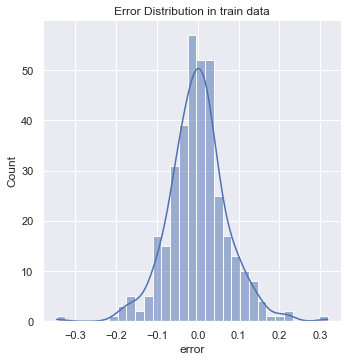

In [66]:
# 1. Check error terms are normally distributed
sns.displot(y_train-y_train_pred,kde=True)
plt.title('Error Distribution in train data')
plt.xlabel('error')

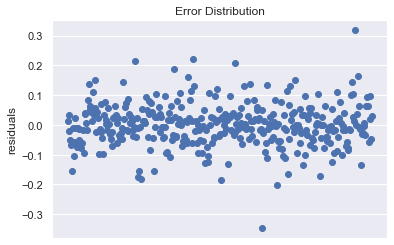

In [67]:
# 2. Check homoscedasticity
x= [i for i in range (1,y_train.shape[0]+1,1)]
plt.scatter(x,y_train-y_train_pred)
plt.title('Error Distribution')
plt.ylabel('residuals')
plt.xticks([])
plt.show()

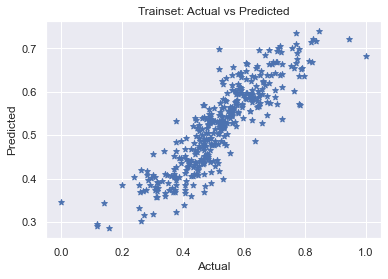

In [68]:
# 3. Linear relationship between actual vs predicted
plt.scatter(y_train, y_train_pred, marker='*')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Trainset: Actual vs Predicted')
plt.show()

### 2. Test Set

Text(0.5, 8.95999999999998, 'error')

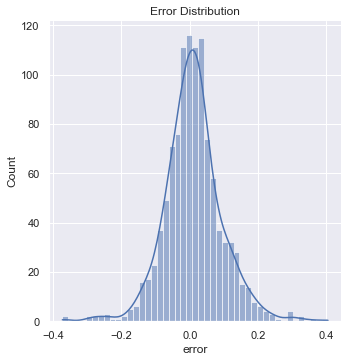

In [69]:
# 1. Check error terms are normally distributed
sns.displot(y_test-y_test_pred,kde=True)
plt.title('Error Distribution')
plt.xlabel('error')

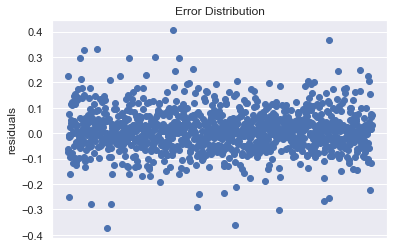

In [70]:
# 2. Check homoscedasticity
x= [i for i in range (1,y_test.shape[0]+1,1)]
plt.scatter(x,y_test-y_test_pred)
plt.title('Error Distribution')
plt.ylabel('residuals')
plt.xticks([])
plt.show()

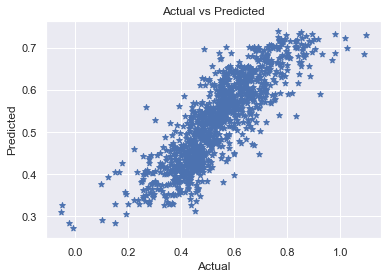

In [71]:
# 3. Linear relationship between actual vs predicted
plt.scatter(y_test, y_test_pred, marker='*')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

#### Residual analysis findings
- From residual analysis both test and train data seem to fit the assumptions of the Linear Regression.
	- Residuals have mean of zero and closely normally distributed.
	- Residuals do not have any pattern hence it has homoscedasticity.

### Question 3

In [73]:
top5_cols = ['GrLivArea', 'GarageCars', 'FireplaceQu', 'BedroomAbvGr','FullBath']

#copy
X_train_copy =X_train.copy(deep=True)
X_test_copy =X_test.copy(deep=True)
X_train_copy.drop(columns = top5_cols, inplace=True)
X_test_copy.drop(columns = top5_cols, inplace=True)

lasso = Lasso()

#model
lsom_4 = GridSearchCV(estimator = lasso,
                    param_grid = params,
                    scoring = 'neg_mean_absolute_error',
                    cv = folds,
                    return_train_score = True,
                    verbose = 1                    
                   )
#fit model
lsom_4.fit(X_train_copy,y_train)

#print best params from gridsearch
print(lsom_4.best_params_)

#fit the best model
lasso_4 = Lasso(alpha = lsom_4.best_params_['alpha'])
lasso_4.fit(X_train_copy, y_train)

#pred on train and test for validation
y_train_pred_q4 = lasso_4.predict(X_train_copy)
y_test_pred_q4 = lasso_4.predict(X_test_copy)

#columns list and coeffs
lasso_q4_rdf = pd.DataFrame(list(zip(X_train_copy.columns,lasso_4.coef_))
                , columns = ['Variable', 'coeff_lasso_q4'])
print(lasso_q4_rdf.sort_values(by='coeff_lasso_q4', ascending = False).head(40))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'alpha': 0.0005}
                 Variable  coeff_lasso_q4
15            OverallQual        0.293151
8                2ndFlrSF        0.117868
25             Fireplaces        0.072147
16            OverallCond        0.050962
2            YearRemodAdd        0.050732
77      HouseStyle_1Story        0.045357
61   Neighborhood_StoneBr        0.043760
36      LotConfig_CulDSac        0.042178
17              ExterQual        0.031530
18               BsmtQual        0.029683
19           BsmtExposure        0.029563
55   Neighborhood_NridgHt        0.029137
43   Neighborhood_ClearCr        0.028328
24            KitchenQual        0.025158
20           BsmtFinType1        0.024707
60   Neighborhood_Somerst        0.021844
90    Exterior1st_BrkFace        0.021658
6               BsmtUnfSF        0.019825
31            MSZoning_RL        0.019783
22           BsmtFullBath        0.017785
3              MasVnrArea        0.016

## Summary and outcomes from this exercise
* top 5 positive relation variable influencing sales price: GrLivArea, GarageCars, FireplaceQu, BedroomAbvGr and FullBath 
* top 5 negative relation variable Sales price: MSZoning_RM, BldgType_Twnh, Exterior1st_Stucco, Age of property,MSSubClass and some Neighborhood influence the sales price negatively
* The residual analysis for both test and train data seem to fit the assumptions of the Linear Regression.
* Clearly we see how lasso and ridge regression could boost the feature selection process for regression problems.
